# Problem definition: Classification of Amyloid PET images into healthy and AD.


In this jupyter notebook, you will learn to classify Amyloid PET images into healthy/congitively normal (CN) and Alzheimer's disease (AD) by using transfer learning using a pre-trained network.


You will learn 2 ways of customizing a pre-trained network:
1. Feature extraction: Use the representations learnt by the pre-trained model to extract features from the new images. You just add a classifer layer which will be trained from scratch on top of the pretrained model. You do not need to retrain the entire model.
2. Fine-tuning: Unfreeze few top layers of the frozen model and jointly train with the newly added classifier layer and the last layers of the base model.This allows us to "fine-tune" the higher order representations in the base model to make it more suitable for the task in hand. .  


**Objectivies (What will we learn here?)**

1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Image augmentation
5. Building the classification model
6. Feature extraction
7. Looking at learning curves
8. Fine-tuning
9. Looking at the learning curves
10. Predicting using the build model
11. What next? It is time to play!

## Step 1: Set up the env

In [ ]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')


tf.config.run_functions_eagerly(True)

print(tf.__version__)

2.15.0


In [ ]:
!sudo apt-get update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,326 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/unive

Let's install pydicom which is the library we will use for reading dicom images

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.2 MB/s eta 0:00:00


In [ ]:
import pydicom

Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

Install gcsfuse it is a package used to mount the cloud bucket on to your local environment.

1. Authenticate your google account

2. Create a new directory to mount the storage bucket

3. Use gcsfuse to mount the storage bucket

4. You can browse throught the storage bucket here

In [1]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v1.4.0/gcsfuse_1.4.0_amd64.deb; \
    dpkg --install gcsfuse_1.4.0_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,305 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/m

Now call google authentication with the following code block and allow access in the pop-up window

In [ ]:
from google.colab import auth
auth.authenticate_user()

Let's set the project id and storage bucket id

In [ ]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


You can list using gsutil to see if we have the correct storage

In [ ]:
!gsutil ls

gs://csc-509-image-files/


Let's make a new directory called images to mount our bucket

In [ ]:
!mkdir images

Call gcsfuse to mount the bucket

In [ ]:
!gcsfuse --implicit-dirs csc-509-image-files images

{"time":"21/12/2023 09:58:37.787801","severity":"INFO","msg":"Start gcsfuse/1.3.0 (Go version go1.21.4) for app \"\" using mount point: /content/images\n"}


In [ ]:
!ls images/

Archive		  Module1_BraTS		 Module1_PET   Module2_ADNI_New
Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI


In [ ]:
!pwd

/content


## Step 2: Now let's create the training, validation and test ids.

In [ ]:
DATA_PATH = Path('/content/images/Module1_PET/PET/')

In [ ]:
csv_file = "/content/images/Module1_PET/adni_pet_metadata_file.csv"

From the data wrangling and preprocessing exercise we have already created a csv with middle slices of the Amyloid PET images. Let's read that csv file.

In [ ]:
# Read Amyloid PET
data_df = pd.read_csv(csv_file)
# data_df = data_df[data_df['SLICE_NUM'] == 48].reset_index(drop = True)
missing= []
for i,r in data_df.iterrows():
  if not(os.path.exists(f"{DATA_PATH}/{r.middle_slice}")):
    print(r.middle_slice)
    missing.append(r.middle_slice)
data_df = data_df[~data_df.middle_slice.isin(missing)].copy()
print(len(data_df))
data_df.head()

AD_CN_baseline_Uniform_Resolution/AD/073_S_5016_I365866/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/024_S_4280_I265274/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/009_S_5224_I386055/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/006_S_4546_I300104/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/006_S_4192_I268115/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/005_S_4910_I342830/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/003_S_4373_I282305/PET_Slice_048.dcm
AD_CN_baseline_Uniform_Resolution/AD/002_S_5018_I347760/PET_Slice_048.dcm
322


,group,folder,n_images,middle_slice_index,subject_id,image_id,middle_slice,copied_from,copied_from1,copied_from2,copied_from3,copied_from4,copied_from5,copied_from6
0,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_437...,96,48,941_S_4376,I283676,AD_CN_baseline_Uniform_Resolution/CN/941_S_437...,ADNI2_baseline_AV45_PET/941_S_4376/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-02-03_15_17_12.0/I283...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120209140414341_48_S1...
1,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_436...,96,48,941_S_4365,I276956,AD_CN_baseline_Uniform_Resolution/CN/941_S_436...,ADNI2_baseline_AV45_PET/941_S_4365/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-01-06_15_23_36.0/I276...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120110093755859_48_S1...
2,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_429...,96,48,941_S_4292,I278427,AD_CN_baseline_Uniform_Resolution/CN/941_S_429...,ADNI2_baseline_AV45_PET/941_S_4292/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-01-11_15_15_55.0/I278...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120117134415635_48_S1...
3,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_425...,96,48,941_S_4255,I268135,AD_CN_baseline_Uniform_Resolution/CN/941_S_425...,ADNI2_baseline_AV45_PET/941_S_4255/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2011-11-18_15_45_01.0/I268...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20111122163122657_48_S1...
4,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_410...,96,48,941_S_4100,I257617,AD_CN_baseline_Uniform_Resolution/CN/941_S_410...,ADNI2_baseline_AV45_PET/941_S_4100/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2011-09-16_15_07_08.0/I257...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20110923133245628_48_S1...


Let's get the folderpath from the middle slice filepaths.

In [ ]:
# data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]

In [ ]:
# # Let's check the groups
# data_df['Group'].unique()

array(['CN', 'MCI', 'LMCI', 'EMCI', 'AD', 'SMC'], dtype=object)

## We already understand what each of these groups mean:

- CN : Cognitively normal
- MCI : Mild cognitive impairment
- EMCI : Early mild cognitive impairment
- LMCI: Late mild cognitive impairment
- AD : Alzheimer's disease
- SMC : Significant memory concerns

Spatial pattern of amyloid deposition in AD: https://onlinelibrary.wiley.com/doi/10.1002/hbm.23018

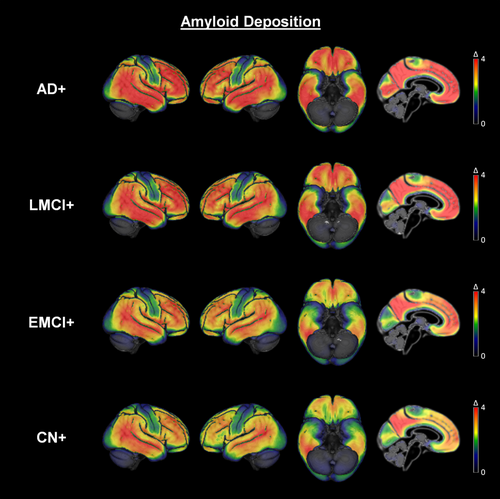



In [ ]:
# # We will train a binary classifier for CN v/s AD, so let's filter for these values of the column Group.
# data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'FOLDERPATH_MIDDLE_SLICES', 'Group' ]]
# data_df_filt = data_df[data_df['Group'].isin(['AD', 'CN'])].reset_index(drop = True)


# print("Number of patient ids:", len(data_df_filt))
# data_df_filt.head()

Number of patient ids: 175


,Image Data ID,FILEPATH_MIDDLE_SLICES,FOLDERPATH_MIDDLE_SLICES,Group
0,I240520,/content/drive/MyDrive/Data_Shortcut/Module1_A...,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
1,I856333,/content/drive/MyDrive/Data_Shortcut/Module1_A...,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
2,I259148,/content/drive/MyDrive/Data_Shortcut/Module1_A...,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
3,I257130,/content/drive/MyDrive/Data_Shortcut/Module1_A...,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
4,I272168,/content/drive/MyDrive/Data_Shortcut/Module1_A...,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN


What are types of classification in deep learning: https://machinelearningmastery.com/types-of-classification-in-machine-learning/

In [ ]:
# Let's check the number of patients with CN and AD
data_df.groupby(by = 'group')['subject_id'].agg('nunique').reset_index()

,group,subject_id
0,AD,141
1,CN,181


About train, validation and test sets: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

Scikit-learn train, validation and test splits: https://stackabuse.com/scikit-learns-traintestsplit-training-testing-and-validation-sets/

In [ ]:
# Split into training, validation set and test set
ids = data_df['middle_slice'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.20)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.20)

In [ ]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 205 patient ids in training set
There are 52 patient ids in validation set
There are 65 patient ids in test set


In [ ]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
data_df['Split'] = np.where(data_df['middle_slice'].isin(train_ids), 'Train', '')
data_df['Split'] = np.where(data_df['middle_slice'].isin(val_ids), 'Validation', data_df['Split'])
data_df['Split'] = np.where(data_df['middle_slice'].isin(test_ids), 'Test', data_df['Split'])

data_df.groupby(by = ['Split','group'])['subject_id'].agg('nunique').reset_index()

,Split,group,subject_id
0,Test,AD,32
1,Test,CN,33
2,Train,AD,85
3,Train,CN,120
4,Validation,AD,24
5,Validation,CN,28


What to do when your train and test data comes from different distributions: https://www.freecodecamp.org/news/what-to-do-when-your-training-and-testing-data-come-from-different-distributions-d89674c6ecd8/

## Step 3: Let's do some image pre-processing. You have already learnt basics of reading and visualizing dicom images, selecting slices and looking at histograms.

Here, we will look at some pre-processing steps specific to classification problem. It's important to understand that the pro-processing steps could vary depending on the task at hand.

One thing to note is the number of patients/images we have per split, per group is not enough to train a CNN model. So we will need to increase the sample size. Instead of using just the middle slice, let's use 10 slices per patient.

Why do we normalize images for deep learning: https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d

How do you know you have enough training data or sample size: https://towardsdatascience.com/how-do-you-know-you-have-enough-training-data-ad9b1fd679ee

In [ ]:
# Let's create a function to normalize the image between 0 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):
  img_array = np.ndarray.flatten(image)
  min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
  img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
  input_image = tf.cast(img_normalized, tf.float32)/255
  input_label = 0 if label == 'CN' else 1
  return input_image, input_label

In [ ]:
# Let's create a function read dicoms and sort by slice number

def read_dicom_slice(dicom_image):
  image = f"{DATA_PATH}/{dicom_image}"
  return pydicom.dcmread(image)

In [ ]:
data_df.middle_slice[0]

'AD_CN_baseline_Uniform_Resolution/CN/941_S_4376_I283676/PET_Slice_048.dcm'

In [ ]:
# Let's create a function to create numpy arrays using the above 2 functions

def create_numpy_array(df):
  X = []
  Y = []
  for idx,row in df.iterrows():
    for a in ['PET_Slice_046','PET_Slice_047',
              'PET_Slice_048','PET_Slice_049','PET_Slice_050']:
      image = read_dicom_slice(row.middle_slice.replace('PET_Slice_048',a)).pixel_array
      image,label = normalize(image,row.group)
      X.append(image)
      Y.append(label)
  # for i in range(len(df)):
  #   print("i:"+ str(i))
  #   dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
  #   print(dicom_volume)
  #   keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
  #   print(keys_sorted)
  #   keys_filt = [46, 47, 48, 49, 50]
  #   for key in keys_filt: # iterates through the dictionary, while the enumerate function keeps track of the index with j
  #       value = dicom_volume[str(key)]
  #       image = value.pixel_array
  #       label = df['Group'][i]
  #       new_image, new_label = normalize(image, label)
  #       X.append(new_image)
  #       Y.append(new_label)
  return np.asarray(X), np.asarray(Y)

In [ ]:
# Let's create numpy arrays for training, validation and test sets using the above 3 functions
X_train, Y_train = create_numpy_array(data_df[data_df['Split'] == 'Train'].reset_index(drop = True))
X_val, Y_val = create_numpy_array(data_df[data_df['Split'] == 'Validation'].reset_index(drop = True))
X_test, Y_test = create_numpy_array(data_df[data_df['Split'] == 'Test'].reset_index(drop = True))

What are numpy arrays: https://www.w3schools.com/python/numpy/numpy_intro.asp

It takes a long time to create the numpy arrays. We just want to execute this step once and save the numpy arrays as .npy files so that we can reuse the files for out hyper-parameter tuning.

**Please change the location of the files to your own location. Else you will overwrite the previously created files in the shared folder.**


In [ ]:
# Let's save the train, validation and test arrays to a path in your drive
#np.save('/content/drive/MyDrive/.../AmyPET_train_images.npy', X_train) # Enter the path where you will save the file
#np.save('/content/drive/MyDrive/.../AmyPET_val_images.npy', X_val)
#np.save('/content/drive/MyDrive/.../AmyPET_test_images.npy', X_test)
#np.save('/content/drive/MyDrive/.../AmyPET_train_label.npy', Y_train)
#np.save('/content/drive/MyDrive/.../AmyPET_val_label.npy', Y_val)
#np.save('/content/drive/MyDrive/.../AmyPET_test_label.npy', Y_test)

Now we will read the .npy files and start our model training!We have a numpy arrays already created and saved in the shared folder.

**Please save a copy of the files to your own location and read files from that location.**

In [ ]:
# # Let's load the train, validation and test arrays
# X_train = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_train_images.npy', allow_pickle=True)
# X_val = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_val_images.npy', allow_pickle=True)
# X_test = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_test_images.npy', allow_pickle=True)
# Y_train = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_train_label.npy', allow_pickle=True)
# Y_val = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_val_label.npy', allow_pickle=True)
# Y_test = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_test_label.npy', allow_pickle=True)

The images are not 3 channel. Inorder to use Imagenet weights, we will need 3 channel images. The next step converts the images to 3 channel.

What are grayscale abd RGB images: https://www.analyticsvidhya.com/blog/2021/03/grayscale-and-rgb-format-for-storing-images/

In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

Because we have mulitple images from same patient, we need to shuffle the training set. We will also shuffle the validation and test sets.

Wht shuffling is recommended in deep learning: https://www.deepwizai.com/simply-deep/why-random-shuffling-improves-generalizability-of-neural-nets

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1025 images in training set
There are 260 images in validation set
There are 325 images in test set


Colormaps in matplotlib: https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/

Text(0.5, 1.0, 'CN')

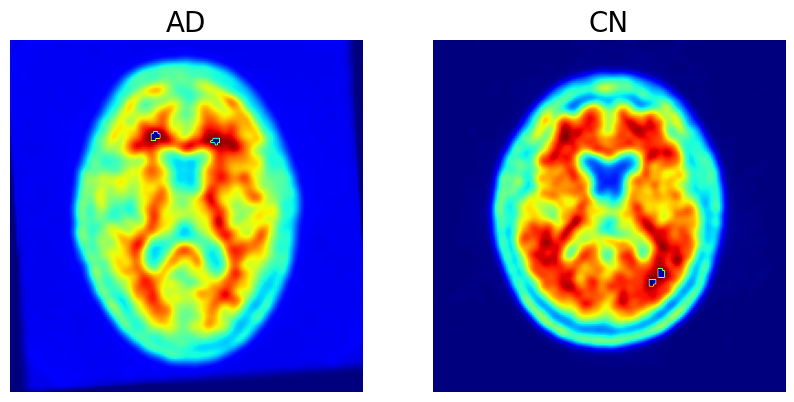

In [ ]:
# Visualize the images
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[7][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title('AD', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(X_train[8][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title('CN', fontsize=20)

In [ ]:
# Let's look at some of the PET images of CN and AD patients
plt.figure(figsize = (20, 100))
for i in range(100):

    plt.subplot(20,5, i+1)
    plt.imshow(X_train[i][:,:,0], cmap = 'jet')
    plt.axis('off')
    plt.title(Y_train[i])


Output hidden; open in https://colab.research.google.com to view.

What are tensors: https://www.tensorflow.org/guide/tensor

What are tensor datasets: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
# Let's create the train, validation and test tensor datasets
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))


2 articiles on effect of batch size on training:
1. https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/#:~:text=Batch%20size%20controls%20the%20accuracy,stability%20of%20the%20learning%20process.

2. https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset_val.batch(BATCH_SIZE)
test_dataset = dataset_test.batch(BATCH_SIZE)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 9
Number of test batches: 11


Optimizing performance with AUTOTUNE: https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4

In [ ]:
# Configure the data for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Step 4: Let's look at image augmentation now.

Augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation. This helps expose the model to different aspects of the training data and reduce overfitting.

Note: Augmentation should be applied only on the training set.

How is augmentation helpful in deep learning: https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

Data augmentation using tensorflow: https://www.tensorflow.org/tutorials/images/data_augmentation

(160, 160, 3)


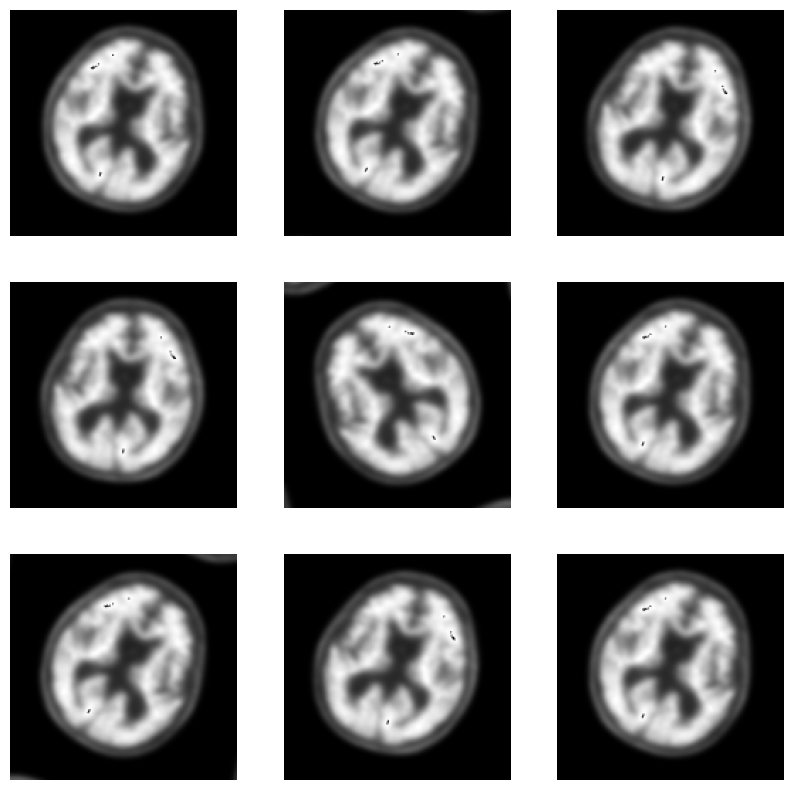

In [ ]:
# Let's look at examples of image augmentation now

# We will create a few pre-processing layers and apply it to the PET image to understand how augmentation works

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]

  print(first_image.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0])
    plt.axis('off')


## Step 5: Let's build our model now. For the first run, we will use InceptionV3 pre-trained network.This model expects pixel values in [-1, 1].

A pre-trained network has already learnt to extract powerful and informative features from natural images and we will use it as a starting point to learn a new task.InceptionV3 is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help  classify CN and AD from this dataset.

First, we will need to pick which layer of InceptionV3 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, we will instantiate an InceptionV3 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

What is Imagenet and what are imagenet weights: https://stackoverflow.com/questions/62739893/why-are-keras-models-instantiated-with-imagenet-weights-only

What are benefits of using pre-trained networks in deep learning: https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

Simple explanation of Inception and how it works: https://www.youtube.com/watch?v=n5VQaJc1b14

Different pre-trained networks available to use: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Create the base model from the pre-trained model InceptionV3
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 79, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 79, 79, 32)           0         ['batch_normalizati

This feature extractor converts each 160x160x3 image into a 3x3x2048 block of features. Let's see what it does to an example batch of images.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


## Step 6: Feature extraction


In this step, we will freeze the convolutional base created from the previous step and use as a feature extractor. Additionally, we will add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.




In [ ]:
# InceptionV3 has many layers, so setting the entire model's trainable flag to False will freeze all of them.
base_model.trainable = False

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When we set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

What is batch normalization: https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338

What is global average pooling:https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/

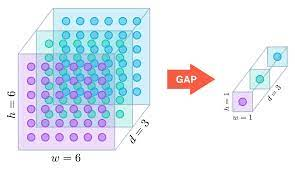

In [ ]:
# Add a classification head.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


We will now apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
We don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

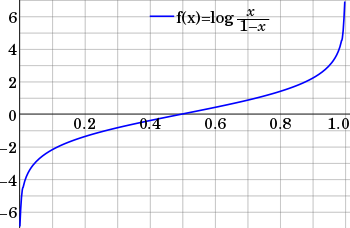

Classification problem in deep learning: https://medium.com/deep-learning-with-keras/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now let's build a model by using everything we have learnt so far -  the data augmentation, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Let's compile the model before training it. Since there are two classes, we will use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output. We will start with a very small learning rate.

What do you mean by model compilation: https://techvidvan.com/tutorials/keras-model-compilation-evaluation-prediction/

We use a fixed learning rate here, is there a way to have anadjustable learning rate: https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler

Learning rate scheduler in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [ ]:
# Compile the model

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

What are the different optimizers in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [ ]:
# Let's look at the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

The 21M parameters in InceptionV3 are frozen, but there are 2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

Let's do the model training now! We will train for 5 epochs.

In [ ]:
# Train the model

initial_epochs =5

loss0, accuracy0 = model.evaluate(val_dataset)

9/9 [==============================] - 3s 308ms/step - loss: 0.8680 - accuracy: 0.4346


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.43


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/5
33/33 [==============================] - 21s 476ms/step - loss: 0.8839 - accuracy: 0.5307 - val_loss: 0.8488 - val_accuracy: 0.4385
Epoch 2/5
33/33 [==============================] - 13s 387ms/step - loss: 0.8632 - accuracy: 0.5512 - val_loss: 0.8315 - val_accuracy: 0.4423
Epoch 3/5
33/33 [==============================] - 13s 402ms/step - loss: 0.8877 - accuracy: 0.5434 - val_loss: 0.8111 - val_accuracy: 0.4731
Epoch 4/5
33/33 [==============================] - 14s 422ms/step - loss: 0.8591 - accuracy: 0.5366 - val_loss: 0.7952 - val_accuracy: 0.4808
Epoch 5/5
33/33 [==============================] - 13s 388ms/step - loss: 0.8515 - accuracy: 0.5522 - val_loss: 0.7806 - val_accuracy: 0.5000


## Step 7: Now let's take a look at the learning curve.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Why is learning curve important: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

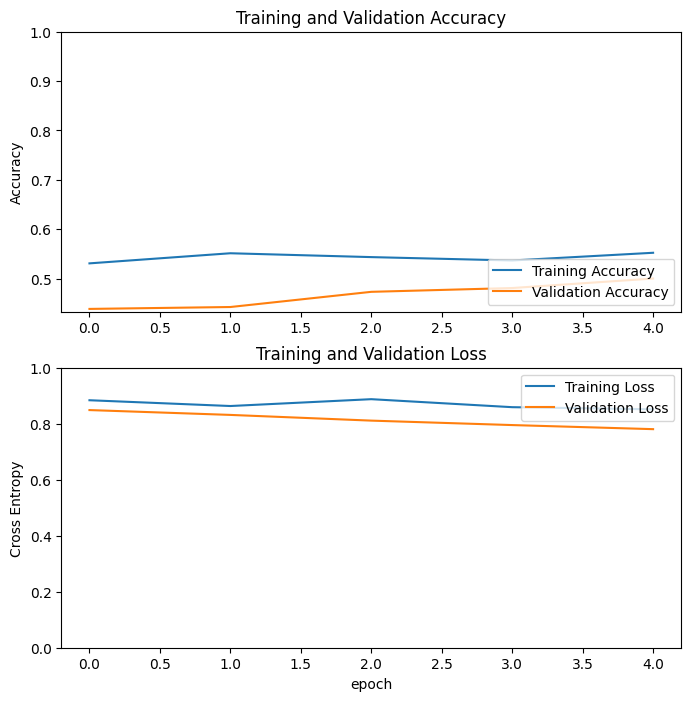

In [ ]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 8: Fine-tuning

In the feature extraction experiment, were were only training a few layers on top of an InceptionV3 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, it's good to note that we should try to fine-tune a small number of top layers rather than the whole InceptionV3 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
# Un-freeze the top layers of the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


Now let's compile the model. As we are training a much larger model and want to readapt the pre-trained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/5),
              metrics=['accuracy'])

In [ ]:
# Let's take a look at the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [ ]:
# Let's look at the number of trainable variables now.
len(model.trainable_variables)

68

Let's continue to train the model. If we were able to train the model to convergence earlier, this step will further improve the accuracy.

Here we have selected a fixed number of epochs.

Is there a way you can stop the model from training when it starts overfitting: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

Early stopping in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/25
33/33 [==============================] - 21s 617ms/step - loss: 0.7221 - accuracy: 0.6215 - val_loss: 0.5755 - val_accuracy: 0.6846
Epoch 6/25
33/33 [==============================] - 18s 534ms/step - loss: 0.5734 - accuracy: 0.7054 - val_loss: 0.5332 - val_accuracy: 0.7115
Epoch 7/25
33/33 [==============================] - 18s 558ms/step - loss: 0.5452 - accuracy: 0.7171 - val_loss: 0.5120 - val_accuracy: 0.7385
Epoch 8/25
33/33 [==============================] - 18s 533ms/step - loss: 0.5107 - accuracy: 0.7659 - val_loss: 0.5051 - val_accuracy: 0.7577
Epoch 9/25
33/33 [==============================] - 19s 565ms/step - loss: 0.4983 - accuracy: 0.7639 - val_loss: 0.4992 - val_accuracy: 0.7654
Epoch 10/25
33/33 [==============================] - 18s 537ms/step - loss: 0.4495 - accuracy: 0.8010 - val_loss: 0.4904 - val_accuracy: 0.7885
Epoch 11/25
33/33 [==============================] - 19s 568ms/step - loss: 0.4451 - accuracy: 0.7971 - val_loss: 0.4720 - val_accuracy: 0.81

## Step 9: Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the InceptionV3 base model and training the classifier on top of it.


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

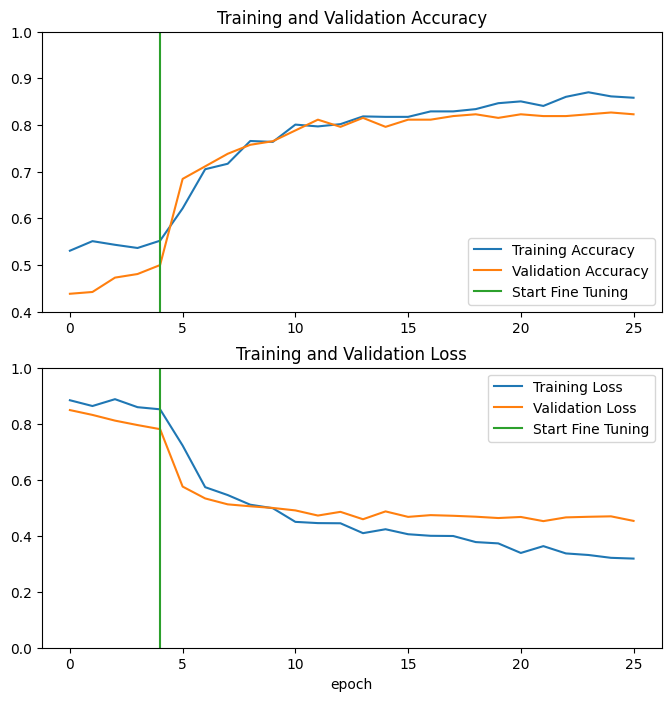

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 10: Evaluate the model.

We can now verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 4s 357ms/step - loss: 0.4181 - accuracy: 0.8369
Test accuracy : 0.8369230628013611


## Step 11: What next? Time to play!
As a home-work or self learning task, you can try a variety of experiments to understand how the model performance is affected.

You can also do some of this as your term project.

Try to think about what could improve the model performance?

1. Will changing the size of training set help? We are just 10 slices per volume, will using more or less slices change anything?
2. Will more data augmentation help improve the performance?
3. Will changing the hyper-parameters like optimizer, learning rate, loss function, epochs, batch size improve the model performance? For ex. What will happen if you change the optimizer to SGD?
4. Will changing the model achitecture help? Check tf.keras.applications for different model architectures like - VGG16, VGG19, ResNet50, etc.
5. How is the learning curve for this trained model? Is it underfitting or overfitting? Does it need more training? How much training is enough and when should I stop?
6. How about using FDG PET instead of Amyloid PET? Will that give a better result?
7. How about using a differnt performance metrics?

And there is so much more! This is just a starting point. Model training and hyper-parameter tuning is the fun part of any deep learning project.

Next what? In this example we learnt a binary or 2 class classification problem. It can be extended to a multi-class problem.

Another fun task to do would be to try a multi-class classification where you can try and predict the different groups like CN, AD, LMCI, etc. What will you need to modify in the current code to change it to a multi-class problem ? (Hint: Loss function, prediction layer)

Multi-lable classification in tensorflow: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

How to do hyper-parameter tuning: https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-deep-neural-nets-by-example-685cb5429a38



In [ ]:
# Some functions to help with model training

# Function to create numpy array for using just 1 slice per volume
def create_numpy_array(df):
    X = []
    Y = []


    for i in range(len(df)):

        ds = pydicom.dcmread(df['FILEPATH_MIDDLE_SLICES'][i])
        image = gray2rgb(ds.pixel_array)
        label = df['Group'][i]
        new_image, new_label = normalize(image, label)
        X.append(new_image)
        Y.append(new_label)

    return np.asarray(X), np.asarray(Y)

In [ ]:
# For using FDG PET

# Let's create a function to normalize the image between -1 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = tf.cast(img_normalized, tf.float32)/255

    input_label = 0 if label == 'CN' else 1


    return input_image, input_label

# Write a function to sort by SliceLocation and select the middle slice from each dicom folder

def select_middle_slice(foldername):

    dicom_files = glob.glob(foldername + "/*.dcm")
    slices = [pydicom.read_file(s) for s in dicom_files]
    slices.sort(key = lambda x: int(x.SliceLocation))
    image = slices[int(len(slices)/2)].pixel_array
    print(np.max(image))


    return gray2rgb(image)

# Let's create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.
def create_numpy_array(df):
    X = []
    Y = []

    for i in range(len(df)):
        print(i)
        folder = df['FILEPATH_FDGPET_DICOM_FOLDER'][i]
        print(folder)
        try:
          image = select_middle_slice(folder)
          label = df['Group'][i]
          new_image, new_label = normalize(image, label)
          X.append(new_image)
          Y.append(new_label)
        except IndexError:
          print("IndexError")
        except AttributeError:
          print("AttributeError")
        except:
          print("InvalidDicomError")



    return np.asarray(X), np.asarray(Y)